In [142]:
import Pkg
packages = [ "Plots", "ProgressBars", "Optim", "LinearAlgebra", "Statistics", "Compat", "ControlSystems"]
Pkg.add(packages)
Pkg.add(path="/opt/julia/local/packages/MobergIO")

  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


   Updating git-repo `/opt/julia/local/packages/MobergIO`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


In [2]:
push!(LOAD_PATH, pwd());

In [3]:
using FurutaProcess
using Plots
using LinearAlgebra
using ControlSystems

In [190]:
##Furuta Model##

J = 0.000154;
la = 0.043;
lp = 0.0323*2;
ma = 0.00544*(la/lp);
mp = 0.00544;
g = 9.82;
f = 0.0; ##friction

α = J + ((1/3)*ma +mp)*la^2;
β = (1/3)*mp*lp^2;
γ = (1/2)*mp*la*lp;
δ = (1/2)*mp*g*lp;

A = [0 1 0 0
    0 -f -((δ*γ)/(α*β-γ^2)) 0
    0 0 0 1
    0 0 ((α*δ)/(α*β-γ^2)) -f];

B = [0
    (β/(α*β-γ^2))
    0
    -(γ/(α*β-γ^2))]; ## Because we are only using one motor to control the base hub

C = [1 0 1 0];

D = 0;

h = 0.02; #timesteps discrete 0.02

sys = ss(A, B, C, D);
dsys, = c2d(sys, h);


### LQR

Q = [0 0 0 0 ### Changed from 1 to zero for LQG
    0 30 0 0
    0 0 100 0
    0 0 0 30];

R = I*0.02;

L = lqr(dsys, Q, R);


### LQG ###

R1 =[1 0 0 0
    0 1 0 0
    0 0 1 0
    0 0 0 1];

R2 = I*1; ##0.01 best

K = kalman(dsys, R1, R2);

##Observability Matrix##

O = obsv(dsys);

r = rank(O);

println(L);
println(K);
println(r);

[0.0 -0.004406463529975785 -0.20570076341048715 -0.014212169750064486]
[-0.5523063823681812; -1.6599908895459914; 1.8427876203688496; 27.818971340683063]
4


In [747]:
function apply_torque(t, T);
    total_time = t
    elapsed_time = 0.0
    sleep_time = 0.01
    torque(T) = sin(50*T)/5
    
    start_time = time()
    
    while elapsed_time < total_time
        
        set_torque!(torque(elapsed_time))
        
        sleep(sleep_time)
        elapsed_time = time() - start_time
    end
    
    set_torque!(0.0)
end    

apply_torque (generic function with 1 method)

In [132]:
function friction(Tu, ϕ̇)
    Tc = 0.05;
    Ts = 0.075;
    ϕ̇e = 0.02;
    
    if (abs(ϕ̇) > ϕ̇e)
        Tf = Tc*sign(ϕ̇);
    elseif (abs(ϕ̇) < ϕ̇e && abs(Tu) < Ts)
        Tf = Tu;
    else
        Tf = Ts*sign(Tu);
    end
    
    Tf;
end

friction (generic function with 1 method)

In [194]:
##Stabilize in position##
enable!();

println("run");
#apply_torque(1, 0.01); ##Create some turbulens
n = 0;
nLQ = 0;

xs = [];
x̂s = [];
xcs = [];
ns = [];
Ts = [];

ϕ, ϕ̇, θ, θ̇ = get_x(); ## LQG initiation
x̂ = [ϕ ϕ̇ θ θ̇]';

while n < 200 
    ϕ, ϕ̇, θ, θ̇ = get_x();
    
    #ϕ = mod(ϕ, 2pi);
    
    x = [ϕ ϕ̇ θ θ̇]';
    ωr = [0 0 pi 0]';
    
    k1 = 0.012;
    k2 = 0.0;
    ω0 = 6;
    
    Tswing = k1*sign((cos(θ) + (θ̇^2)) / (2*ω0*2 - 1) * θ̇*cos(θ) ) - k2*ϕ̇;
    Tu, = -L*(x-ωr); ##Tu = u,
    Tf = 0.0*sign(ϕ̇); ##friction(Tu, ϕ̇);

    xc = dsys.A*x+dsys.B*Tu; ## For experiment plot
    
    x̂ = (dsys.A - dsys.B*L - K*C)*(x̂-ωr) + K*C*(x-ωr) + ωr;
    T̂u, = -L * (x̂-ωr);
    
    T = [Tu T̂u Tswing]';
    
    push!(xs, x); ## For plot
    push!(x̂s, x̂);
    push!(xcs, xc);
    push!(ns, n);
    push!(Ts, T); ## Negative value for plot
    
    if(θ < deg2rad(200) && θ > deg2rad(160)) ### LQR θ < 220 LQR θ > 140
            set_torque!(Tu);
        if(nLQ == 0)
            println(n);
            nLQ = n;
        end
    else
        set_torque!(Tswing); #Tswing
    end
    
    if (get_energy_flag())
        println("FLAGGED");
        break;
    end
        
    sleep(h); ##0.02 for LQR see h.
    
#     println(dsys.A - dsys.B*L - K*C)
#     println("")
#     println((dsys.A - dsys.B*L - K*C)*(x̂-ωr))
#     println("")
#     println(K*C*(x-ωr))
#     println("")
    
    n += 1;
end

set_torque!(0.0);
disable!();
println("finished");

phis = [ x[1] for x in xs ];
dphis = [ x[2] for x in xs ];
thetas = [ x[3] for x in xs ];
dthetas = [ x[4] for x in xs ];

phisEstimate = [ x̂[1] for x̂ in x̂s ];
dphisEstimate = [ x̂[2] for x̂ in x̂s ];
thetasEstimate = [ x̂[3] for x̂ in x̂s ];
dthetasEstimate = [ x̂[4] for x̂ in x̂s ];

torqueT = [ T[1] for T in Ts ];
torqueT̂ = [ T[2] for T in Ts ];
torqueSwing = [ T[3] for T in Ts ];

phisCalc = [ xc[1] for xc in xcs ];
thetasCalc = [ xc[3] for xc in xcs ];

run
69
finished


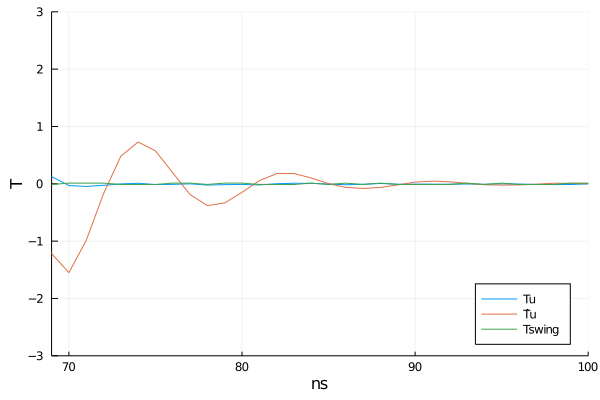

In [195]:
plot(ns, torqueT, xlabel = "ns", ylabel = "T", label = "Tu", legend=:bottomright, xlims = (nLQ,100), ylims = (-3, 3))
plot!(ns, torqueT̂, label = "T̂u")
plot!(ns, torqueSwing, label = "Tswing")

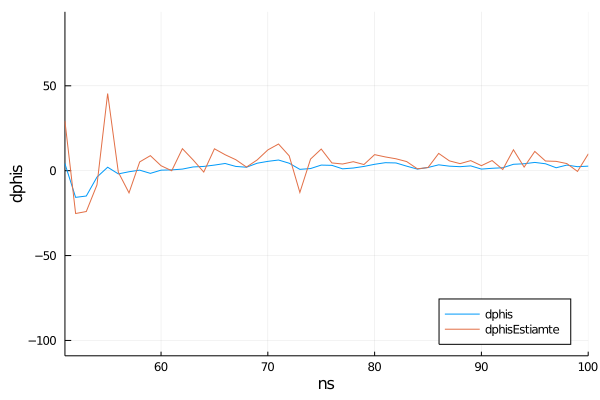

In [188]:
plot(ns, dphis, xlabel = "ns", ylabel = "dphis", label = "dphis", legend=:bottomright, xlims = (nLQ, 100))
plot!(ns, dphisEstimate, label = "dphisEstiamte")

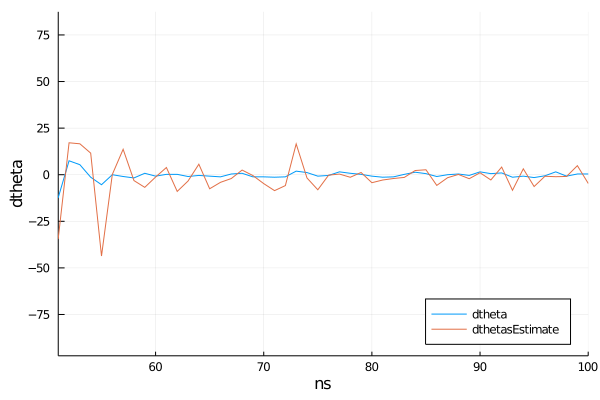

In [189]:
plot(ns, dthetas, xlabel = "ns", ylabel = "dtheta", label = "dtheta", legend=:bottomright, xlims = (nLQ,100))
plot!(ns, dthetasEstimate, label = "dthetasEstimate")

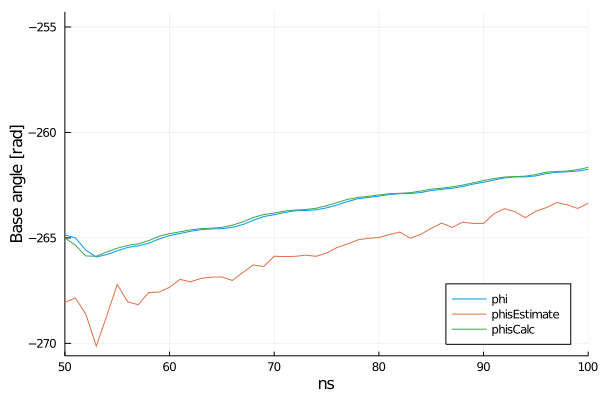

In [180]:
plot(ns, phis, xlabel = "ns", ylabel = "Base angle [rad]", label = "phi", legend=:bottomright, xlims = (nLQ,100))
plot!(ns, phisEstimate, label = "phisEstimate")
plot!(ns, phisCalc, label = "phisCalc")

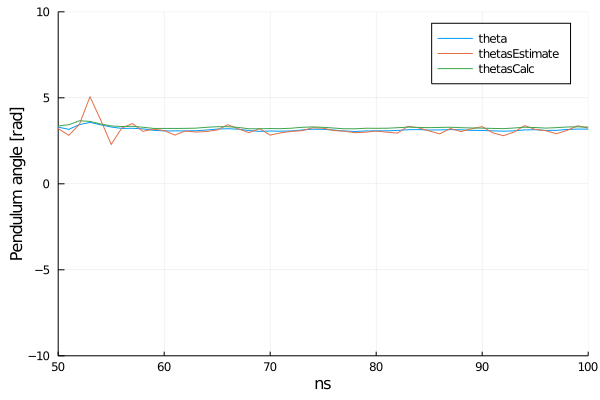

In [179]:
plot(ns, thetas, xlabel = "ns", ylabel = "Pendulum angle [rad]", label = "theta", xlims = (nLQ,100), ylims = (-10, 10))
plot!(ns, thetasEstimate, label = "thetasEstimate")
plot!(ns, thetasCalc, label = "thetasCalc")

In [751]:
println(dsys.A - dsys.B*L - K*C)
println()
println(dsys.A)
println()
println(dsys.B*L)
println()
println(K*C)

[1.1283574868824566 0.02555357948092909 0.385419762271624 0.01789743935579415; 0.7563261266720341 1.5555597486055208 26.470234869756275 1.7896608846170141; -1.3752235614472825 -0.0055872470459691756 -0.5878929186481254 0.002299430454128039; -16.01600604338272 -0.5631660995715498 -37.45199614866927 -0.7682290993340681]

[0.9999999999999929 0.019999999999999858 -0.002187868410955226 -1.4539495666059664e-5; 0.0 0.9999999999999929 -0.22052601383759524 -0.0021878684109552303; 0.0 0.0 1.0481524434213234 0.020319997418002316; 0.0 0.0 4.8535215148560225 1.0481524434213245]

[0.0 -0.005553579480929234 -0.25925014380011546 -0.01791197885146021; 0.0 -0.5555597486055278 -25.93443475692184 -1.7918487530279694; 0.0 0.0055872470459691756 0.26082180062216637 0.018020566963874277; 0.0 0.5631660995715498 26.289511620142566 1.8163815427553927]

[-0.1283574868824638 0.0 -0.1283574868824638 0.0; -0.7563261266720341 0.0 -0.7563261266720341 0.0; 1.3752235614472825 0.0 1.3752235614472825 0.0; 16.0160060433827

In [122]:
reset!();

In [17]:
apply_torque(-0.05, 0.2)

-4.76837158203125e-7

In [121]:
get_x()

(-283.8846432100445, 4.76837158203125e-7, 6.262817862565953, 4.76837158203125e-7)

In [66]:
##Harmonic oscilator experiemnt##

A = [0 1;-1 -0.1];
B = [0; 1];
C = [1 0];
D = 0;
R1 = I*0.0001;
R2 = I*0.0001;
Q = [1 0; 0 1];
R = I;
h = 0.02;
ϕ = pi/2;

x = [0 0]';
ωr = [0 0]';
x̂ = x;
x̂s = [];
ts = [];

sys = ss(A, B, C, D);
dsys, = c2d(sys, h);

K = kalman(dsys, R1, R2);
L = lqr(dsys, Q, R);

for t = 1:1000
    ϕ = ϕ + 0.01;
    x = [ϕ 0]';
    push!(x̂s, x̂);
    push!(ts, t);
    x̂ = (dsys.A - dsys.B*L - K*C)*(x̂-ωr) + K*C*(x-ωr);
end

phisEstimate = [ x̂[1] for x̂ in x̂s ];
dphisEstimate = [ x̂[2] for x̂ in x̂s ];

println((dsys.A - dsys.B*L - K*C))
println(K*C)

[0.3643884199337827 0.019730253073667776; -0.5544760765304247 0.9729685500253284]
[0.6353324626242706 0.0; 0.5265745633611415 0.0]


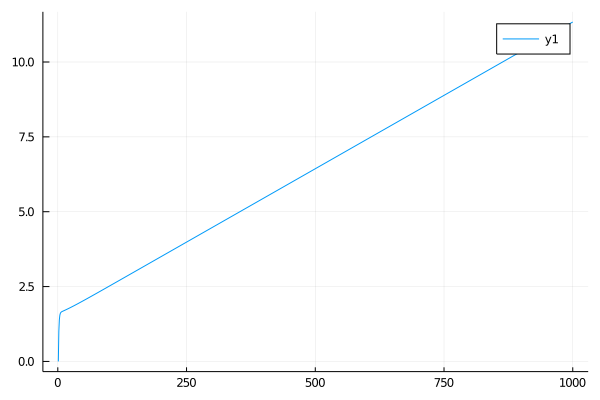

In [67]:
plot(ts, phisEstimate)

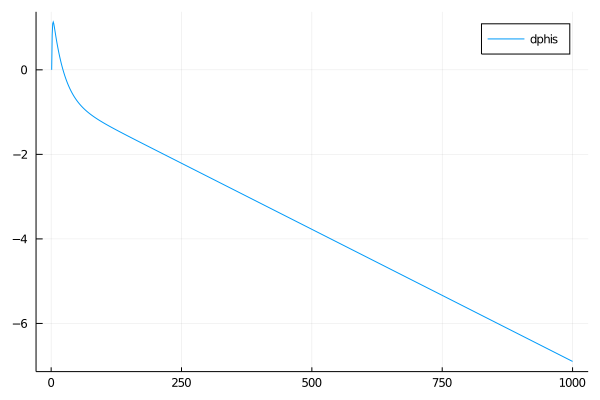

In [68]:
plot(ts, dphisEstimate, label = "dphis")